<a href="https://colab.research.google.com/github/ihagoSantos/image-analysis-and-computer-vision/blob/main/keras_pre_trained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando Rede Pré-treinada

Uma rede pré-treinada é uma rede salva que tenha sido anteriormente treinada em um grande dataset, geralmente em uma tarefa de classificação de imagem em larga escala.

Se esse conjunto de dados original for grande o suficiente e geral o suficiente, as features aprendidas pela rede pré-treinada pode atuar efetivamente como um modelo genérico e podem ser úteis para muitos problemas diferentes de visão computacional

Por exemplo, pode-se treinar uma rede no ImageNet (onde as classes são principalmente animais e objetos do cotidiano) e, em seguida, redirecionar essa rede treinada para algo mais específico.

Aqui, vamos considerar uma grande convnet treinada do dataset ImageNet (1,4 milhão de imagens rotuladas e 1000 classes diferentes). O ImageNet contém muitas classes de animais, incluindo diferentes espécies de cães e gatos (nosso objetivo)

Usaremos a arquitetura VGG16, desenvolvida por Karen Simonyan e Andrew Zisserman em 2014, uma arquitetura de convnet simples e amplamente usada para o ImageNet.

Há duas maneiras de aproveitar uma rede pré-treinada: **extração de features** e **fine tuning**.

# Extração de Features

Utiliza as representações aprendidas por uma rede anterior para extrair features de novas amostras. Estas features são executadas através de um novo classificador, treinado a partir do zero.

Lembre-se que as convnet usadas para classificação são divididas em duas partes: camadas convolucionais e de pooling para extração de features (chamada de base convolucional) e camadas densas para classificação.

Normalmente, as features aprendidas pelas camadas convolucionais são mais genéricas e reutilizáveis (as representações aprendidas pelas camadas densass de classificação são mais específicas e não devem ser reutilizadas).

Vamos usar a base convolucional da rede VGG16, treinada no ImageNet, para extrair features de imagens de gatos e cães e, em seguida, treinar um classificador de gato versus cachorro sobre essas features.

O modelo VGG16, entre outros, vem pré-embalado com Keras.

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Argumentos:

**weights**, de onde queremos inicializar o modelo

**include_top**, se refere à inclusão ou não do classificador densely-connected na parte superior da rede. Por padrão, esse classificador densely-connected corresponderia às 1000 classes do ImageNet. Como pretendemos usar nosso próprio classificador densely-connected (com apenas duas classes, gato e cachorro), não vamos incluí-lo.

**input_shape**, o formato dos tensores de imagem (opcional).

In [2]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

O feature-map final tem forma (4, 4, 512). Esse é a fature onde colocaremos um classificador fully-connecteds.

Aqui, podemos proceder de duas formas:

**1 -** Executando a base convolucional sobre nosso conjunto de dados, gravando sua saída em um array Numpy no disco e, em seguida, usando esses dados como entrada para um classificador (fully-connecteds).

Solução rápida porque requer a execução da base convolucional apenas uma vez para cada imagem de entrada.

No entanto, essa técnica não nos permitiria aproveitar o data augmentation do keras (teriamos que implementar o nosso próprio data augmentation).

**2 -** Estendendo o modelo que temos (conv_base) adicionando camadas Densas na parte superior e executando tudo de ponta a ponta nos dados de entrada.

Vamos tentar a primeira opção:

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2025-03-13 22:26:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  29.3MB/s    in 2.2s    

2025-03-13 22:26:15 (29.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import os
import zipfile

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'data/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))

  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )

  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[ i*batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1

    if i * batch_size >= sample_count:
      # Note that since generators yield data indefinitely in a loop,
      # we must `break` after every image has been seen once.
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)


Found 2000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/

AS features extraídas são da forma (samples, 4, 4, 512). Vamos adicionar um classificador densamente conectado;
Portanto, primeiro devemos aplicar flatten para (samples, 8192)

In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512)) # aplica flatten manualmente
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

In [12]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.5701 - loss: 0.7282 - val_acc: 0.8160 - val_loss: 0.4479
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7941 - loss: 0.4700 - val_acc: 0.8460 - val_loss: 0.3691
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8361 - loss: 0.3919 - val_acc: 0.8640 - val_loss: 0.3321
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8482 - loss: 0.3457 - val_acc: 0.8730 - val_loss: 0.3133
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8707 - loss: 0.3124 - val_acc: 0.8740 - val_loss: 0.2984
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8910 - loss: 0.2820 - val_acc: 0.8720 - val_loss: 0.2914
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9012 - loss: 0.2604 - val_acc: 0.8760 - val_loss: 0.2869
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9068 - loss: 0.2500 - val_acc: 0.8810 - val_loss: 0.2785
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

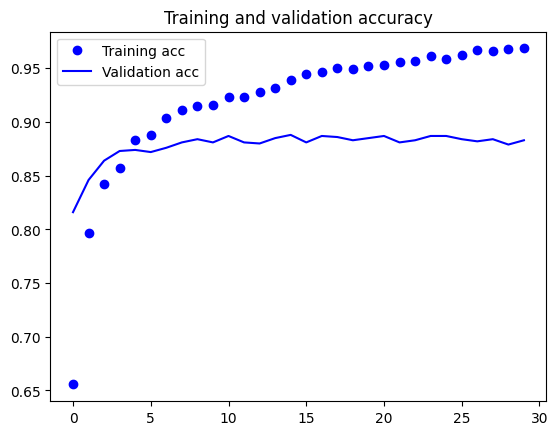

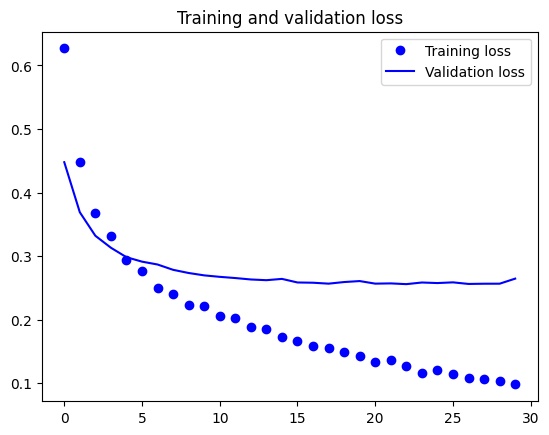

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Observe que a acurácia do modelo no conjunto de validação já foii melhor do que anteriormente (com data augmentation e sem usar a VGG16)

*Obs.: Veja o notebook "unidade03_keras_extract-features.ipynb" antes de continuarmos*

A outra forma de fazer é (opção 2) estendendo o modelo que temos (conv_base) adicionando camadas Densas na parte superior e executando tudo de ponta a ponta nos dados de entrada. Muito mais lento (necessário o uso de GPU).

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
input_shape=(None, 150, 150, 3)
model.build(input_shape)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

A base convolucional do VGG16 possui 14.714.688 parâmetros, o que é muito grande. O classificador que estamos adicionando no topo tem 2 milhões de parâmetros.

Antes de compilar e treinar nosso modelo, uma coisa muito importante a fazer é "freeze" a base convolucional (VGG16). "Freezing" uma camada ou conjunto de camadas significa impedir que seus pesos sejam atualizados durante o treinamento.

Se não fizer isso, as representações aprendidas anteriormente pela base convolucional (VGG16) serão modificadas durante o treinamento. Como as camadas densas na parte superior são inicializadas aleatoriamente, atualizações dos pesos seriam propagadas pela rede, destruindo o modelo pré-treinado.


In [16]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [17]:
# Freezing a base convolucional
conv_base.trainable = False

In [18]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


com essa configuração, apenas os pesos das duas camadas Densas que adicionamos serão treinados

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # this is the target directory
    train_dir,
    # all images will be resized to 150x150
    target_size=(150, 150),
    batch_size=20,
    # sence we use binary_crossentropy loss, we neet binary labels
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 - 23s - 228ms/step - acc: 0.6790 - loss: 0.6007 - val_acc: 0.8240 - val_loss: 0.4513
Epoch 2/30
100/100 - 19s - 189ms/step - acc: 0.7755 - loss: 0.4847 - val_acc: 0.8300 - val_loss: 0.3813
Epoch 3/30
100/100 - 20s - 204ms/step - acc: 0.8050 - loss: 0.4356 - val_acc: 0.8580 - val_loss: 0.3425
Epoch 4/30
100/100 - 20s - 200ms/step - acc: 0.8145 - loss: 0.4123 - val_acc: 0.8630 - val_loss: 0.3203
Epoch 5/30
100/100 - 19s - 194ms/step - acc: 0.8270 - loss: 0.3818 - val_acc: 0.8610 - val_loss: 0.3098
Epoch 6/30
100/100 - 20s - 204ms/step - acc: 0.8425 - loss: 0.3674 - val_acc: 0.8710 - val_loss: 0.2967
Epoch 7/30
100/100 - 19s - 193ms/step - acc: 0.8430 - loss: 0.3599 - val_acc: 0.8720 - val_loss: 0.2935
Epoch 8/30
100/100 - 19s - 191ms/step - acc: 0.8430 - loss: 0.3514 - val_acc: 0.8730 - val_loss: 0.3040
Epoch 9/30
100/100 - 19s - 189ms/step - acc: 0.8305 - loss: 0.3571 - val_acc: 0.8820 - val_loss: 0.2766
Epoch 10/30
100/100 - 21s - 205ms/step - acc: 0.8470 - loss: 0.3

In [21]:
model.save('cats_and_dogs_small_3.h5')

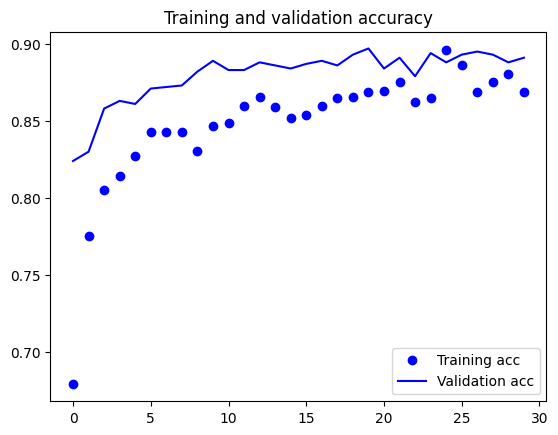

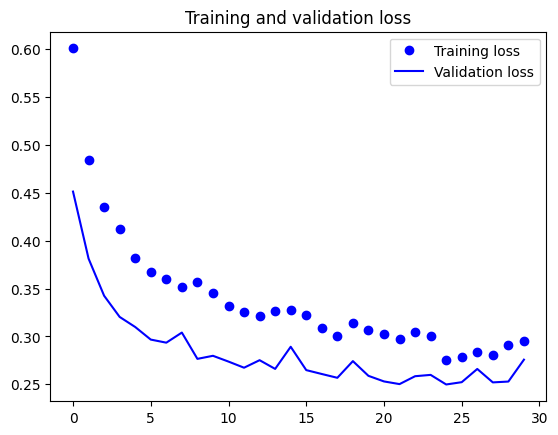

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fining-tuning

Consiste em descongelar algumas das camadas superiores de uma base de modelo congelada usada para extração de features e treinar em conjunto a parte recém-adicionada do modelo (no nosso caso, o classificador) e essas camadas superiores.

Isso ajusta levemente as representações mais abstratas do modelo que está sendo reutilizado, a fim de torná-las mais relevantes para o problema em questão.

Congelamos a base convolucional da VGG16 para poder treinar um classificador inicializado aleatoriamente no topo.

Pelo mesmo motivo, só é possível ajustar as camadas superiores da base convolucional depois que o classificador na parte superior já tiver sido treinado.

Portanto, as etapas para o fine-tuning de uma rede são as seguintes:

1) Adicione sua rede personalizada (a nossa rede) em cima de uma rede básica já treinada (VGG16). 2) Congele a rede base (VGG16). 3) Treine a parte que adicionada (o que acabamos de fazer). 4) Descongele algumas camadas na rede base (da VGG16). 5) Treine em conjunto essas duas camadas (VGG16 com algumas camadas descongeladas mais o nosso modelo de classificação).

Vamos descongelar nossa conv_base e congelaremos camadas individuais dentro dela.

Ajustaremos as três últimas camadas convolucionais, o que significa que todas as camadas até block4_pool (veja a VGG original abaixo) devem ser congeladas e as camadas block5_conv1, block5_conv2 e block5_conv3 devem ser treináveis.

Optamos por apenas ajudar as últimas camadas e não as primeiras porque estas últimas aprendem representação mais específicas (para o nosso caso, preferimos as representações mais genéricas)

In [23]:
# VGG16 original (base convolucional)
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainabme = True
  else:
    layer.trainable = False

In [25]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      # epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 236ms/step - acc: 0.9473 - loss: 0.1256 - val_acc: 0.9330 - val_loss: 0.2237
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - acc: 0.9565 - loss: 0.1268 - val_acc: 0.9380 - val_loss: 0.2109
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - acc: 0.9558 - loss: 0.1122 - val_acc: 0.9380 - val_loss: 0.2009
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - acc: 0.9623 - loss: 0.0909 - val_acc: 0.9300 - val_loss: 0.2428
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - acc: 0.9683 - loss: 0.0892 - val_acc: 0.9370 - val_loss: 0.1915
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - acc: 0.9708 - loss: 0.0848 - val_acc: 0.9380 - val_loss: 0.2430
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - acc: 0.9667 - loss: 0.0929 - val_acc: 0.9430 - val_loss: 0.1909
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - acc: 0.9765 - loss: 0.0759 - val_acc: 0.9360 - val_loss: 0.2044
Epoch 9/30
100/100 ━━━━━━━━━━━━━

In [29]:
model.save('cats_and_dogs_small_4.h5')

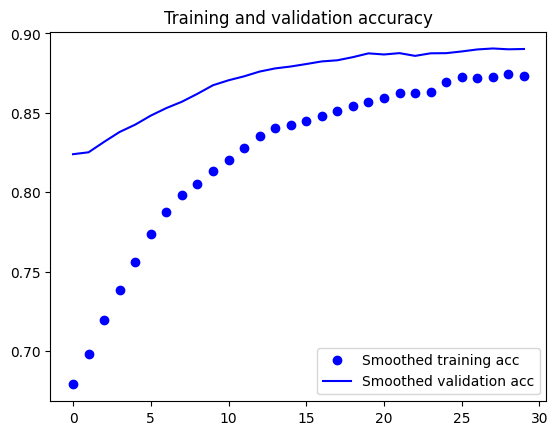

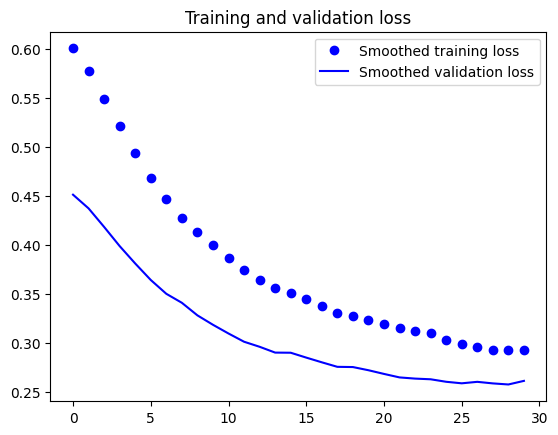

In [30]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Se você tiver um conjunto de teste, utile-o para testar o modelo  

In [33]:
test_generator = test_datagen.flow_from_directory(
        validation_dir, #test_dir
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.9337 - loss: 0.3052
test acc: 0.9399999976158142


Referência: François Chollet. Deep Learning with Python. November 2017